<a href="https://colab.research.google.com/github/dksifoua/AbricotJustfy/blob/master/1%20-%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 13 12:24:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Dependencies

In [2]:
import os
import bs4
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.3.0


## Prepare data

In [3]:
%%time
!mkdir -p ./data
!wget --no-check-certificate \
    https://data.deepai.org/PASCALVOC2007.zip \
    -O ./data/pascal-voc-2007.zip
!unzip -q ./data/pascal-voc-2007.zip -d ./data
!rm -r ./data/pascal-voc-2007.zip

--2020-10-13 11:27:17--  https://data.deepai.org/PASCALVOC2007.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774851628 (1.7G) [application/x-zip-compressed]
Saving to: ‘./data/pascal-voc-2007.zip’

./data/pascal-voc-2 100%[===================>]   1.65G  20.5MB/s    in 84s     

2020-10-13 11:28:42 (20.0 MB/s) - ‘./data/pascal-voc-2007.zip’ saved [1774851628/1774851628]

CPU times: user 601 ms, sys: 177 ms, total: 778 ms
Wall time: 1min 44s


In [56]:
TRAIN_VAL_IMAGE_PATH = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
TRAIN_VAL_ANNOTATION_PATH = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/'
TEST_IMAGE_PATH = './data/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
TEST_ANNOTATION_PATH = './data/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations/'

***Parse XML image annotations***

In [44]:
def parse_xml(path):
    contents = open(path).read()
    soup = bs4.BeautifulSoup(contents, 'html.parser')
    filename = soup.find('filename').string
    objects = []
    for obj in soup.find_all('object'):
        objects.append({
            'name': obj.find('name').string,
            'truncated': obj.find('truncated').string,
            'difficult': obj.find('difficult').string,
            'xmin': int(obj.find('xmin').string),
            'ymin': int(obj.find('ymin').string),
            'xmax': int(obj.find('xmax').string),
            'ymax': int(obj.find('ymax').string)
        }) 
    return filename, objects


def get_annotations(path, description=None):
    annotations = {}
    for fn in tqdm.tqdm(os.listdir(path), desc=description):
        filename, objects = parse_xml(os.path.join(path, fn))
        annotations[filename] = objects
    return annotations


train_val_annotations = get_annotations(path=TRAIN_VAL_ANNOTATION_PATH, description='Load train/val annotations')
test_annotations = get_annotations(path=TEST_ANNOTATION_PATH, description='Load test annotations')

Load test annotations: 100%|██████████| 4952/4952 [00:16<00:00, 299.16it/s]


In [55]:
LABELS = []
for annotations in train_val_annotations.values():
    for annotation in annotations:
        LABELS.append(annotation['name'])
LABELS = [*set(LABELS)]
print(f'Number of objects: {len(LABELS):,}')
print(LABELS)

Number of objects: 20
['bicycle', 'cow', 'person', 'horse', 'sofa', 'aeroplane', 'boat', 'sheep', 'dog', 'motorbike', 'bird', 'cat', 'train', 'tvmonitor', 'bottle', 'car', 'chair', 'bus', 'diningtable', 'pottedplant']


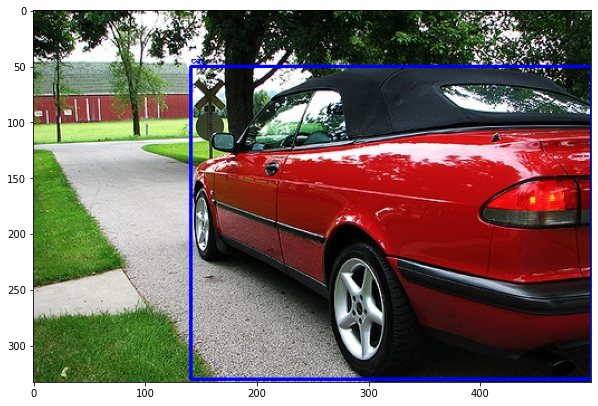

In [39]:
image = cv2.imread(os.path.join(IMAGE_PATH, '000007.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
for annotation in annotations['000007.jpg']:
    name = annotation['name']
    xmin, ymin = annotation['xmin'], annotation['ymin']
    xmax, ymax = annotation['xmax'], annotation['ymax']
    cv2.putText(image, name, (xmin, ymin - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
plt.imshow(image)

***Intersection Over Union***

In [46]:
def compute_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	
    # return the intersection over union value
	return iou

***Create the object detection dataset***

In [ ]:
MAX_POSITIVE_ROI = 30
MAX_NEGATIVE_ROI = 30 * len(LABELS)
BASE_OBJECT_DETECTION_DATASET_PATH = './data/odd/'
TRAIN_OBECT_DETECTION_DATASET_PATH = './data/odd/train/'
VAL_OBECT_DETECTION_DATASET_PATH = './data/odd/val/'
TEST_OBECT_DETECTION_DATASET_PATH = './data/odd/test/'

selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for fn in tqdm.tqdm(os.listdir(IMAGE_PATH)):
    # Load the image and convert it to RGB format
    image = cv2.imread(os.path.join(IMAGE_PATH, fn))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truth image bounding boxes
    annotations = annotations[fn]
    
    # Run selective search on the image
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    rectangles = selective_search.process()

    # Convert generated bounding boxes from (x, y, w, h) to (xmin, ymin, xmax, ymax)
    bndboxes = []
    for (x, y, w, h) in rectangles:
        bndboxes.append((x, y, x + w, y + h))
    
    counters = {name: 0 for name in LABELS}
    for bndbox in bndboxes:
        prop_xmin, prop_ymin, prop_xmax, prop_ymax = bndbox

        for annotation in annotations:
            name = annotation['name']
            xmin, ymin = annotation['xmin'], annotation['ymin']
            xmax, ymax = annotation['xmax'], annotation['ymax']

            iou = compute_intersection_over_union(bndbox, (xmin, xmax, ymin, ymax))

            roi, roi_path = None, None
            if iou > 0.7 and counters[name] <= MAX:
                roi = image[prop_ymin:prop_ymax, prop_xmin:prop_xmax]
                roi_fn = '{}.jpg'.format(counters[name])
                roi_path
    




Working on several AI projects in Natural Language Processing & Computer Vision